In [52]:
import os
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import dill
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [27]:

data_directory = '/alzheimer/Roberto/Allen_Institute/Visual/'  # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

In [3]:
out = []
for session_id in tqdm(sessions.index):
    try:
        with open(f'/alzheimer/Roberto/Allen_Institute/Processed_lfps/lfp_errors_{session_id}.pkl', 'rb') as f:
            errors, noise, time_non_increasing = dill.load(f)
            out.append([errors, noise, time_non_increasing])
    except:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 485.52it/s]


In [4]:
time_is_monotonic = pd.DataFrame([e for q in out for e in q[2]], columns=["session_id", "non monotonic"])
noise_artifact = pd.DataFrame([e for q in out for e in q[1]], columns=["session_id", "artifacts (start (s), stop (s))"])
session_id = pd.Series([q[0][0] for q in out], name="session_id")
mistakes = pd.Series([True if len(q[0][1]) > 0 else False for q in out], name="mistakes present")
lfp_identity = pd.concat([session_id, mistakes], axis=1)


In [28]:
time_is_monotonic = pd.read_csv("/scratch/Roberto/Dropbox/temp/time_is_monotonic")
noise_artifact = pd.read_csv("/scratch/Roberto/Dropbox/temp/noise_artifact")
lfp_identity = pd.read_csv("/scratch/Roberto/Dropbox/temp/lfp_identity")

## non monotonic

In [29]:
time_is_monotonic

,probe_id,non monotonic
0,810755797,False
1,810755801,False
2,810755805,False
3,810755807,False
4,810755803,False
...,...,...
320,848037570,False
321,848037572,False
322,848037578,False
323,848037576,False


In [30]:
time_is_monotonic[time_is_monotonic["non monotonic"]==True]

,probe_id,non monotonic
43,769325786,True


In [31]:
probes = cache.get_probes()
session_id  = probes.loc[time_is_monotonic[time_is_monotonic["non monotonic"]==True]["probe_id"]]["ecephys_session_id"].values[0]
session_id

743475441

In [32]:
session = cache.get_session_data(session_id)  

lfp = session.get_lfp(769325786)

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

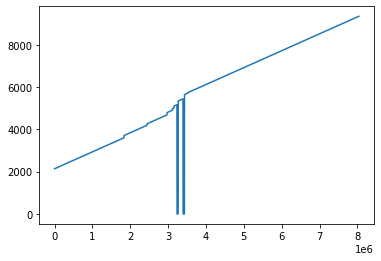

In [36]:
plt.plot(lfp.time)

## Noise/ weird flat lfp events

In [34]:
noise_artifact

,probe_id,"artifacts (start (s), stop (s))"
0,810755797,[]
1,810755801,[]
2,810755805,[]
3,810755807,[]
4,810755803,[]
...,...,...
320,848037570,"[[3579.039602406044, 3579.044402368562]]"
321,848037572,[]
322,848037578,[]
323,848037576,"[[1417.6926347527433, 1417.6998346788637], [79..."


In [47]:
#63 probes weird events
noise_artifact[noise_artifact["artifacts (start (s), stop (s))"].map(lambda d: len(d)) > 2]

,probe_id,"artifacts (start (s), stop (s))"
7,729445648,"[[926.4967247364325, 926.5359247790343]]"
8,729445652,"[[927.0543434878801, 927.0607434884153], [927...."
9,729445656,"[[0.6247691749819921, 9665.641737504]]"
11,729445654,"[[0.6255450943187597, 9665.623830058521]]"
13,760213137,"[[897.2575957258839, 897.2639957321163], [1202..."
...,...,...
316,868297133,"[[349.1146722663334, 349.11867223180894], [344..."
317,868297131,"[[3442.3561982142646, 3442.360998165373]]"
318,841431758,"[[349.0239155591253, 349.03111549160354], [349..."
320,848037570,"[[3579.039602406044, 3579.044402368562]]"


## in 2 sessions lfps are duplicated across probes

In [35]:
lfp_identity

,session_id,mistakes present
0,715093703,False
1,719161530,False
2,721123822,False
3,732592105,False
4,737581020,False
5,739448407,False
6,742951821,False
7,743475441,False
8,744228101,False
9,746083955,True


In [56]:
with open('/scratch/Roberto/Dropbox/temp/lfp_sample.pkl', 'rb') as f:
    lfp_sample, channels = dill.load(f)

In [57]:
to_check = np.concatenate(lfp_sample, axis=1)
channels = np.concatenate(channels)
errors = []
for n, column in enumerate(to_check.T):
    if np.array(range(to_check.shape[1]))[np.sum(np.equal(column, to_check.T), axis=1) > 999].shape[0] > 1:
        errors.append([n, np.array(range(to_check.shape[1]))[np.sum(np.equal(column, to_check.T), axis=1) > 999]])
if len(errors) > 0:
    print (f"Lfp errors in session {session_id}")
else:
    print(f"All fine in session {session_id}")
errors = (session_id, errors)

Lfp errors in session 743475441


In [58]:
errors[0]

743475441